# Classification and Feature Selection -- Random Forest
We use Random Forest for our binary classification of Blood Cancer. In particular, we will explore:
1. Variable Importance
1. Pruning (cost complexity)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from imblearn.over_sampling import SMOTE
import itertools
from pprint import pprint

from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, RandomizedSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve

%matplotlib inline
plt.style.use('seaborn-white')

### 1. Understanding the data

In [2]:
blood_train = pd.read_csv("dataset/blood_training.csv")
blood_test = pd.read_csv("dataset/blood_test.csv")

In [3]:
blood_train.shape, blood_test.shape

((817, 17395), (205, 17395))

In [4]:
blood_train.columns # has DepMap_ID and label

Index(['DepMap_ID', 'A1BG..1.', 'A1CF..29974.', 'A2M..2.', 'A2ML1..144568.',
       'A3GALT2..127550.', 'A4GALT..53947.', 'A4GNT..51146.', 'AAAS..8086.',
       'AACS..65985.',
       ...
       'ZWINT..11130.', 'ZXDA..7789.', 'ZXDB..158586.', 'ZXDC..79364.',
       'ZYG11A..440590.', 'ZYG11B..79699.', 'ZYX..7791.', 'ZZEF1..23140.',
       'ZZZ3..26009.', 'label'],
      dtype='object', length=17395)

In [5]:
blood_test.columns # has DepMap_ID and label

Index(['DepMap_ID', 'A1BG..1.', 'A1CF..29974.', 'A2M..2.', 'A2ML1..144568.',
       'A3GALT2..127550.', 'A4GALT..53947.', 'A4GNT..51146.', 'AAAS..8086.',
       'AACS..65985.',
       ...
       'ZWINT..11130.', 'ZXDA..7789.', 'ZXDB..158586.', 'ZXDC..79364.',
       'ZYG11A..440590.', 'ZYG11B..79699.', 'ZYX..7791.', 'ZZEF1..23140.',
       'ZZZ3..26009.', 'label'],
      dtype='object', length=17395)

In [6]:
sum(blood_train.label == 1)/len(blood_train)

# only 11% of obs has labelled as blood cancer --> imbalanced class, thus need some more care
# Let us keep it as it is, later we adjust the minority class with SMOTE

0.11015911872705018

In [7]:
X_train = blood_train.drop(['DepMap_ID', 'label'], axis = 1)
y_train = blood_train['label']

X_test = blood_test.drop(['DepMap_ID', 'label'], axis = 1)
y_test = blood_test['label']

### 2. Random Forest classifier
Imbalance dataset, weighted class, NO pruning. We start by specifying a few parameters: n_estimators (since deafult is 100), bootstrap, oob_score and class_weight (since we already know we have an imbalaced class)

In [8]:
rf = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                    n_estimators = 500, class_weight = "balanced_subsample",
                    bootstrap = True, oob_score = True)

In [9]:
rf.fit(X_train, y_train)
print('Training score: ', rf.score(X_train, y_train))
print('Test score: ', rf.score(X_test, y_test))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training score:  1.0
Test score:  0.9365853658536586


We see that the Training score is perfect and the Test score is also high. It seems a good result.
To be sure about it, let us plot both the confusion matrix and the ROC curve.

In [15]:
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)
print(f'The accuracy of the model is {round(accuracy_score(y_test, y_pred), 3)*100} %')

print(f'Predicted {y_pred.sum()} obs out of {y_test.sum()} True obs')

The accuracy of the model is 93.7 %
Predicted 6 obs out of 19 True obs


In [12]:
# Confusion matrix
def plot_confusion_matrix(cm, classes, normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Reds):

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                fontsize = 20,
                horizontalalignment = "center",
                color = "white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', size = 18)
        plt.xlabel('Predicted label', size = 18)

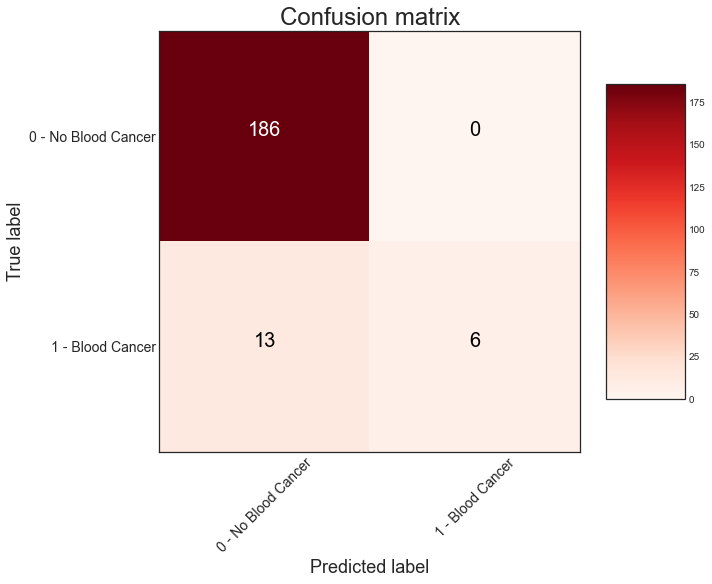

In [13]:
# Let us plot it
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['0 - No Blood Cancer', '1 - Blood Cancer'])

As we can see, our classifier has not detect well Blood-cancer obs: just 1/3 has been correctly classified.

Why then the test score is so hight? Simply because Blood-cancer cells form a minority class, thus there cannot be so many misclassification errors (at most 11%)

However, our aim is to classify these cancer cells, so our RF classifier needs some adjustments. Before moving on, let us plot the ROC curve. 

In [16]:
# ROC curve plot

def evaluate_model(y_pred, y_test, probs, y_train, train_predictions, train_probs):
    baseline = {}
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    results['recall'] = recall_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} - Test: {round(results[metric], 2)}, Train: {round(train_results[metric], 2)}')

    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16

    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'k--', label = 'Baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'Model')
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
    plt.show()

In [17]:
train_predictions = rf.predict(X_train)
train_probs = rf.predict_proba(X_train)[:, 1]
probs = rf.predict_proba(X_test)[:, 1]

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC Score: {roc_auc_score(y_test, probs)}')

Train ROC AUC Score: 1.0
Test ROC AUC Score: 0.9997170345217884


Recall Baseline: 1.0 - Test: 0.32, Train: 1.0
Precision Baseline: 0.09 - Test: 1.0, Train: 1.0
Roc Baseline: 0.5 - Test: 1.0, Train: 1.0


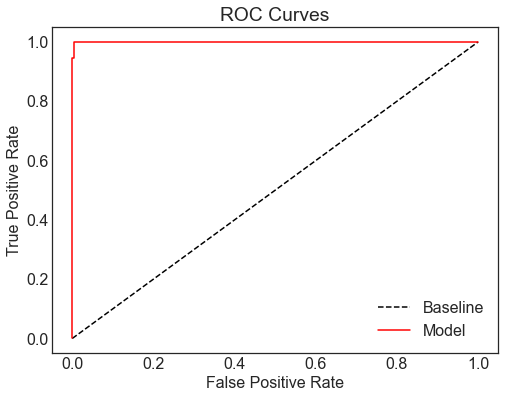

In [40]:
evaluate_model(y_pred, y_test, probs, y_train, train_predictions, train_probs)

As mentioned above, our RF classifier is not perfoming well on the minority class. So, let us use random grid to select the best model, based on the ROC_AUC score, hence scoring = 'roc_auc'.

If this will not be not enough, then we should use the SMOTE function to adjust the cardinality of the minority class.

In [26]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 50)]
max_features = ['auto', 'log2']  # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(2, 68, num = 11)]   # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10]  # Minimum number of samples required to split a node
min_samples_leaf = [4, 10, 25, 50]    # Minimum number of samples required at each leaf node
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': [None] + list(np.linspace(10, 50, 200).astype(int))}

rf_cl = RandomForestClassifier(n_jobs = -1, class_weight = "balanced_subsample",
                bootstrap = True, oob_score = True)

rf_random = RandomizedSearchCV(
                estimator = rf_cl,
                param_distributions = random_grid,
                cv = 5, n_iter = 2, # 50
                verbose = 1, random_state = 2311, 
                scoring = 'roc_auc')

In [27]:
# Finally, fit the data
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: 

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(oob_score=True),
                   n_iter=2,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 8, 15, 21, 28, 35, 41,
                                                      48, 54, 61, 68, None],
                                        'max_features': ['auto', 'log2'],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 11, 11, 11, 11,
                                                           11, 12, 12, 12, 12,
                                                           12, 13, 13, 13, 13,
                                                           13, 14, 14, 14, 14,
                                                           14, 15, 15, 15, 15, ...],
                                        'min_samples_leaf': [1, 4, 10],
                                        'mi

In [28]:
rf_random.cv_results_

{'mean_fit_time': array([101.44232988,   0.71496944]),
 'std_fit_time': array([6.57572535, 0.05769712]),
 'mean_score_time': array([0.40862913, 0.        ]),
 'std_score_time': array([0.11459327, 0.        ]),
 'param_n_estimators': masked_array(data=[504, 516],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[10, 10],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[4, 10],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_leaf_nodes': masked_array(data=[35, 45],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['auto', 'log2'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[48, 35],
              mask=[False, False

In [29]:
rf_random.best_params_

{'n_estimators': 504,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_leaf_nodes': 35,
 'max_features': 'auto',
 'max_depth': 48,
 'bootstrap': True}

We use this information to decide parameters of the new RF classifier. Then, we perform a similar analysis as before.

RMK: this has been done several times, but all the trials have been ommited. We just keep our best choice.

In [95]:
rf = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                    n_estimators = 500, max_depth = 45,
                    min_samples_split = 20, min_samples_leaf = 25,
                    class_weight = "balanced_subsample",
                    bootstrap = True, oob_score = True)

In [96]:
rf.fit(X_train, y_train)
print('Training score: ', rf.score(X_train, y_train))
print('Test score: ', rf.score(X_test, y_test))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training score:  0.996328029375765
Test score:  0.9951219512195122


The accuracy of the model is 99.5 %
Predicted 18 obs out of 19 True obs


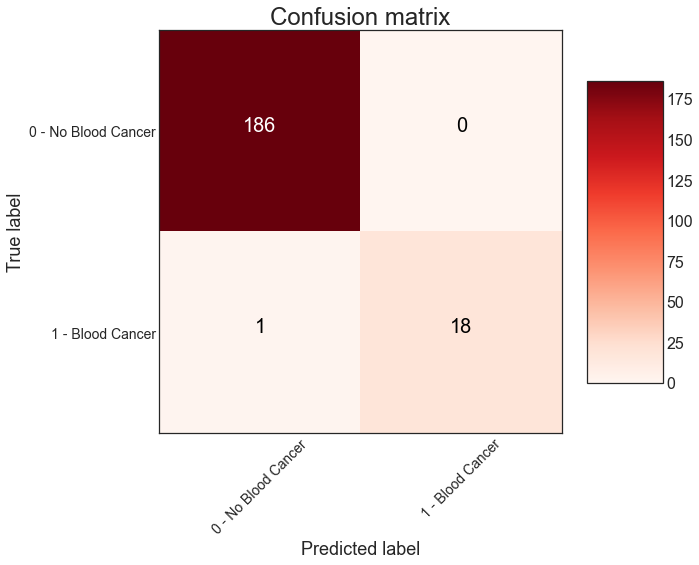

In [97]:
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)
print(f'The accuracy of the model is {round(accuracy_score(y_test, y_pred), 3)*100} %')

print(f'Predicted {y_pred.sum()} obs out of {y_test.sum()} True obs')

plot_confusion_matrix(confusion_matrix(y_test, y_pred),
                classes = ['0 - No Blood Cancer', '1 - Blood Cancer'])

In [98]:
train_predictions = rf.predict(X_train)
train_probs = rf.predict_proba(X_train)[:, 1]
probs = rf.predict_proba(X_test)[:, 1]

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC Score: {roc_auc_score(y_test, probs)}')

Train ROC AUC Score: 0.9999541494727189
Test ROC AUC Score: 0.9994340690435767


Recall Baseline: 1.0 - Test: 0.95, Train: 0.99
Precision Baseline: 0.09 - Test: 1.0, Train: 0.98
Roc Baseline: 0.5 - Test: 1.0, Train: 1.0


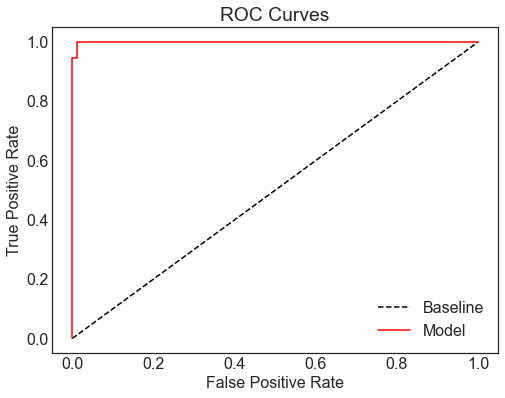

In [99]:
evaluate_model(y_pred, y_test, probs, y_train, train_predictions, train_probs)

Let us have a look at hte most important variables found by this RF classifier.

In [100]:
feat_impo = pd.DataFrame(rf.feature_importances_,
                        index = X_train.columns,
                        columns = ['Importance']).sort_values('Importance', ascending = False)

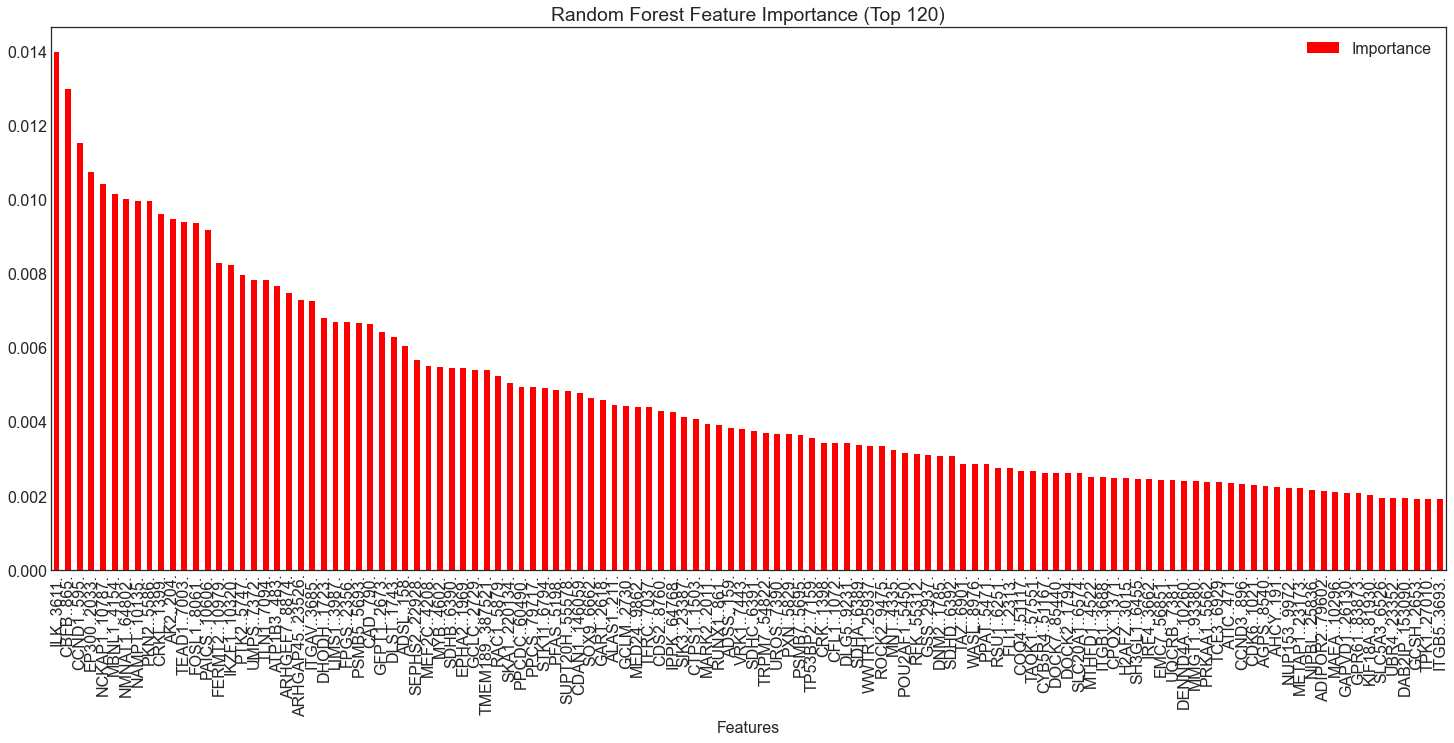

In [101]:
feat_impo[:120].plot.bar(figsize = (25, 10), color = 'r')
plt.title('Random Forest Feature Importance (Top 120)')
plt.xlabel('Features')
plt.show()

We are very proud of this classification. Even if the dataset is imbalanced, the build-in algorithm adapts well giving proper weigths.

### 3. 5-fold cross validation and Feature selection
Let us try a 5-fold cross-validation to validate the model's performance and finding the optimal parameters

In [102]:
# Our current parameters
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 45,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 25,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 2311,
 'verbose': 0,
 'warm_start': False}


In [103]:
# 5-Fold Cross validation to validate the model
print(f'The mean cross validation score is: {np.mean(cross_val_score(rf, X_train, y_train, cv = 5))}')

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: 

The mean cross validation score is: 0.9840715247643275


We have 98.8% of mean accuracy, thus a SMOTE correction is not needed.

Our aim now is to remove unnecessary features from the data to reduce noise and possibly get better performance. In particular, we will perform a 5-fold cross validation to reach this aim. The idea is to get the feature importance values from each of the 5 models built in the 5-fold cross-validation and then take the average of the 5 importance values for each feature in order to select the top N features for the final model.

In [104]:
out = cross_validate(rf, X_train, y_train, cv = 5, n_jobs = -1,
                scoring = 'accuracy', return_estimator = True)

type(out)

dict

In [105]:
feat_impo_all = []
for i, estimator in enumerate(out['estimator']):
    print("First 10 features sorted by their importance for model n. {}:".format(i+1))
    feat_impo = pd.DataFrame(estimator.feature_importances_,
                            index = X_train.columns,
                            columns = ['Importance{}'.format(i+1)]).sort_values('Importance{}'.format(i+1), ascending = False)
    print(feat_impo[:10])
    print('--------------------------------------------------------------')

    feat_impo_all.append(feat_impo[feat_impo['Importance{}'.format(i+1)] > 0.001])

First 10 features sorted by their importance for model n. 1:
                Importance1
CBFB..865.         0.012869
CCND1..595.        0.012307
MBNL1..4154.       0.012283
NMNAT1..64802.     0.012277
ILK..3611.         0.012002
PKN2..5586.        0.010792
NCKAP1..10787.     0.010707
EP300..2033.       0.010184
NAMPT..10135.      0.009791
CRKL..1399.        0.009473
--------------------------------------------------------------
First 10 features sorted by their importance for model n. 2:
                Importance2
CBFB..865.         0.013200
NCKAP1..10787.     0.012207
PKN2..5586.        0.011279
NAMPT..10135.      0.011183
CCND1..595.        0.011073
ILK..3611.         0.011022
MBNL1..4154.       0.010778
FERMT2..10979.     0.010478
FOSL1..8061.       0.009632
PTK2..5747.        0.009141
--------------------------------------------------------------
First 10 features sorted by their importance for model n. 3:
                  Importance3
CBFB..865.           0.014028
CCND1..595.    

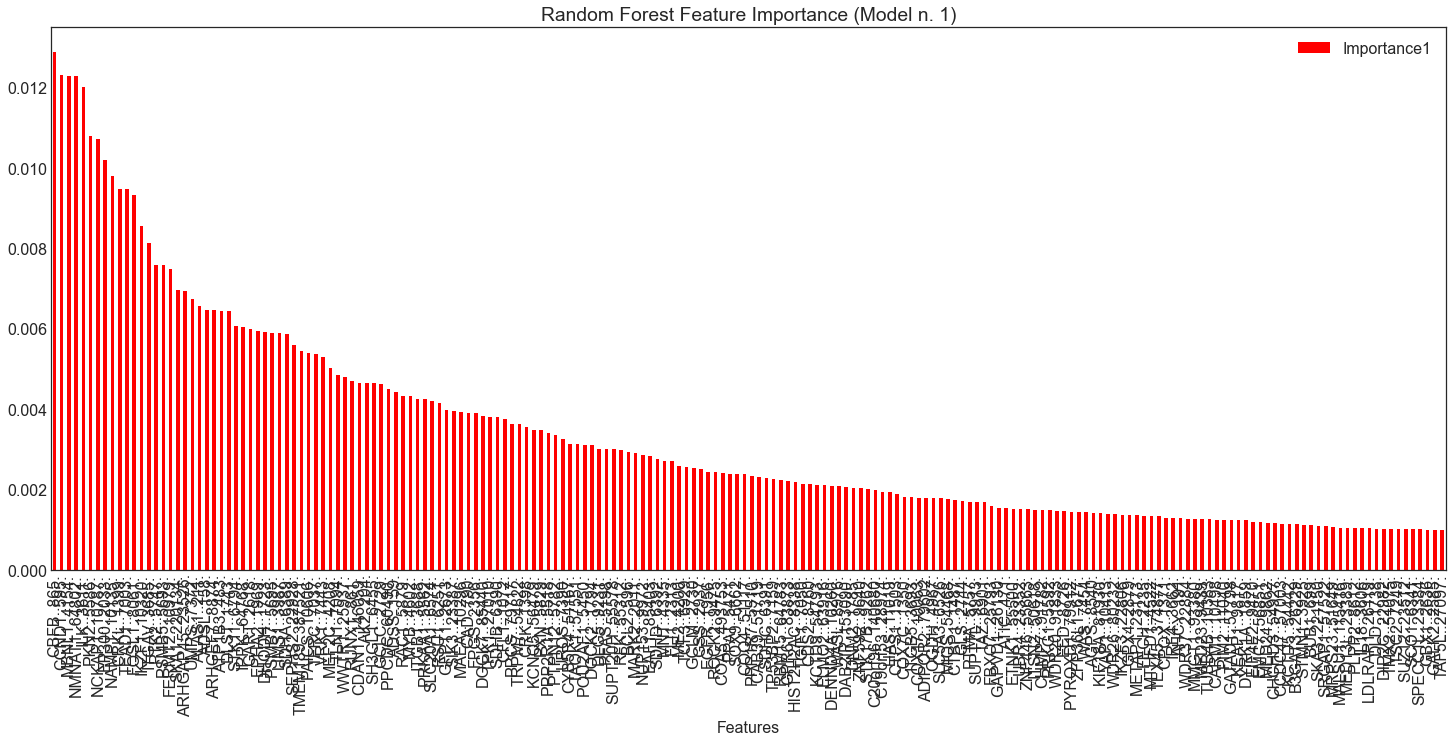

In [106]:
feat_impo_all[0].plot.bar(figsize = (25, 10), color = 'r')
plt.title('Random Forest Feature Importance (Model n. 1)')
plt.xlabel('Features')
plt.show()

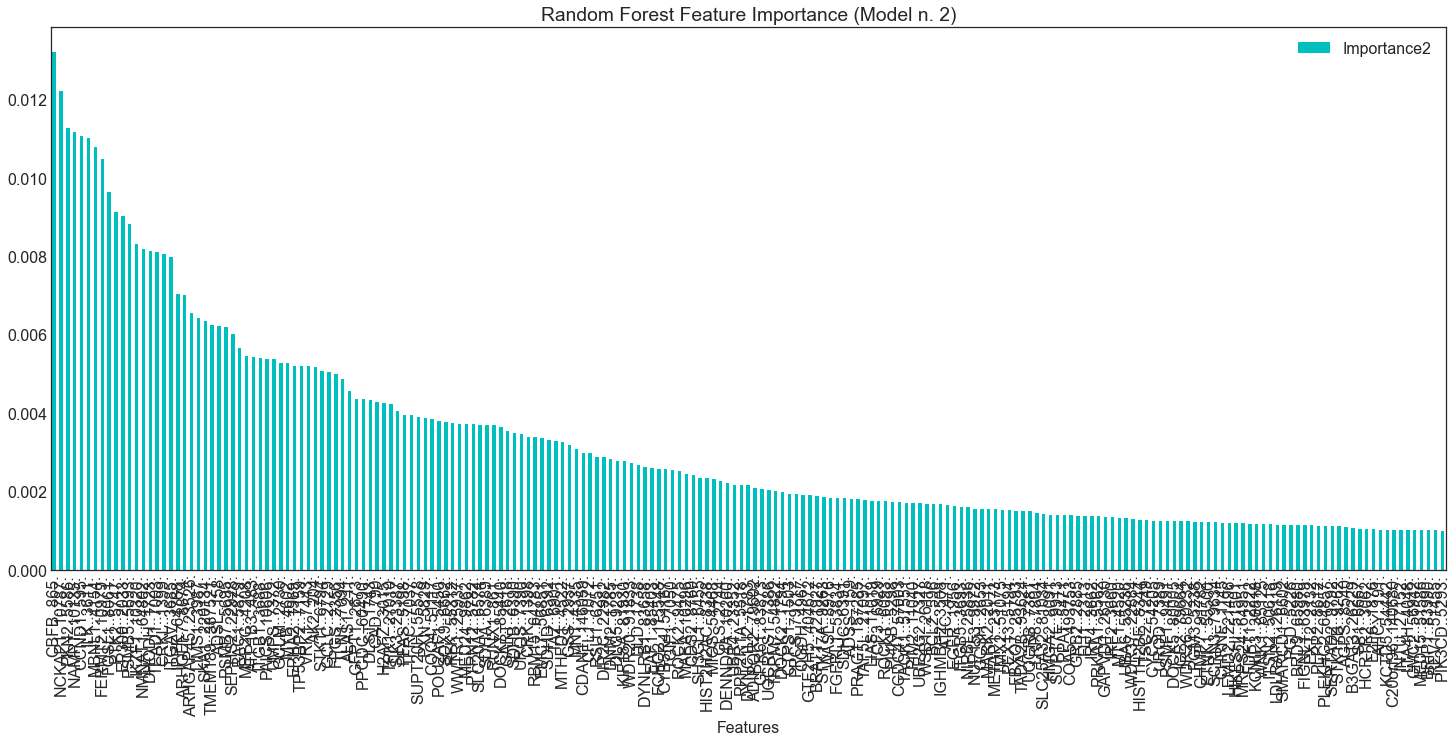

In [107]:
feat_impo_all[1].plot.bar(figsize = (25, 10), color = 'c')
plt.title('Random Forest Feature Importance (Model n. 2)')
plt.xlabel('Features')
plt.show()

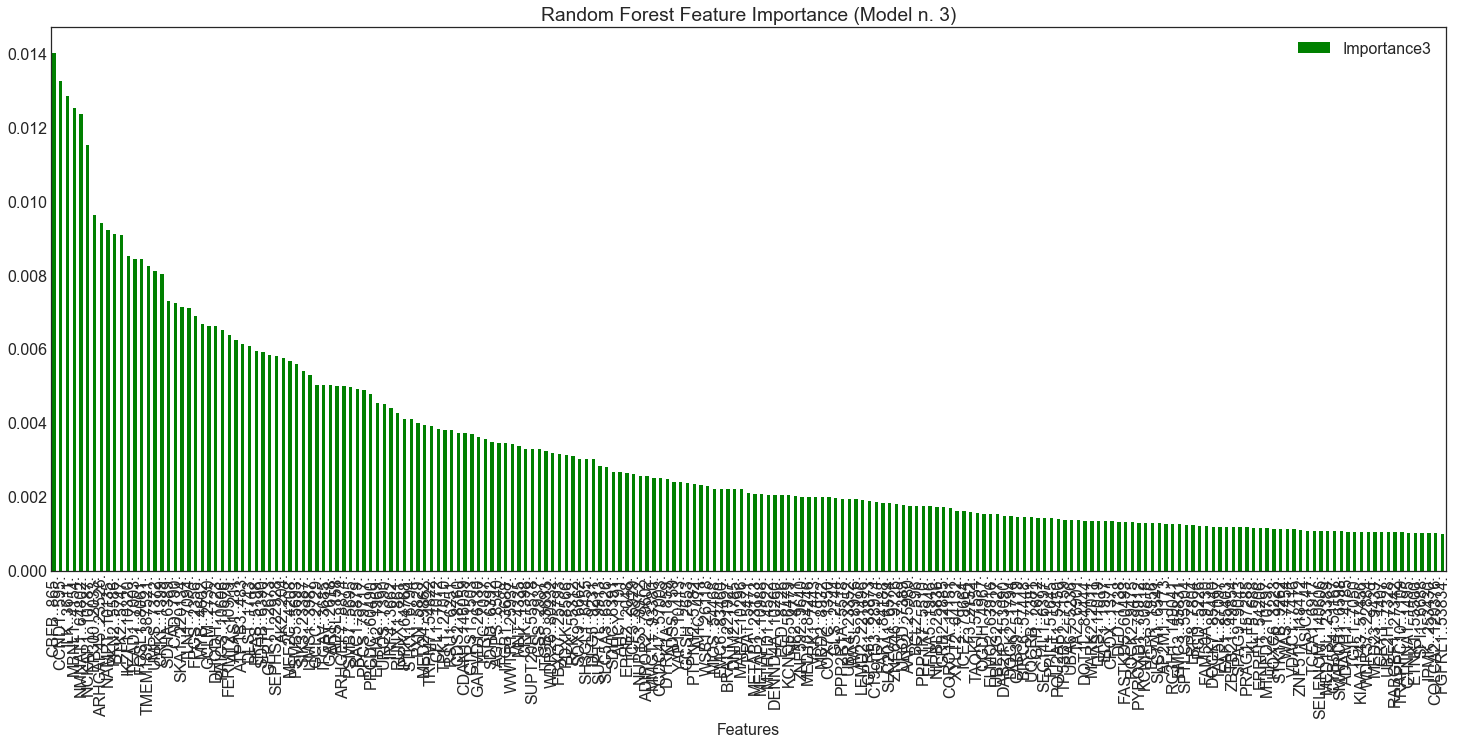

In [108]:
feat_impo_all[2].plot.bar(figsize = (25, 10), color = 'g')
plt.title('Random Forest Feature Importance (Model n. 3)')
plt.xlabel('Features')
plt.show()

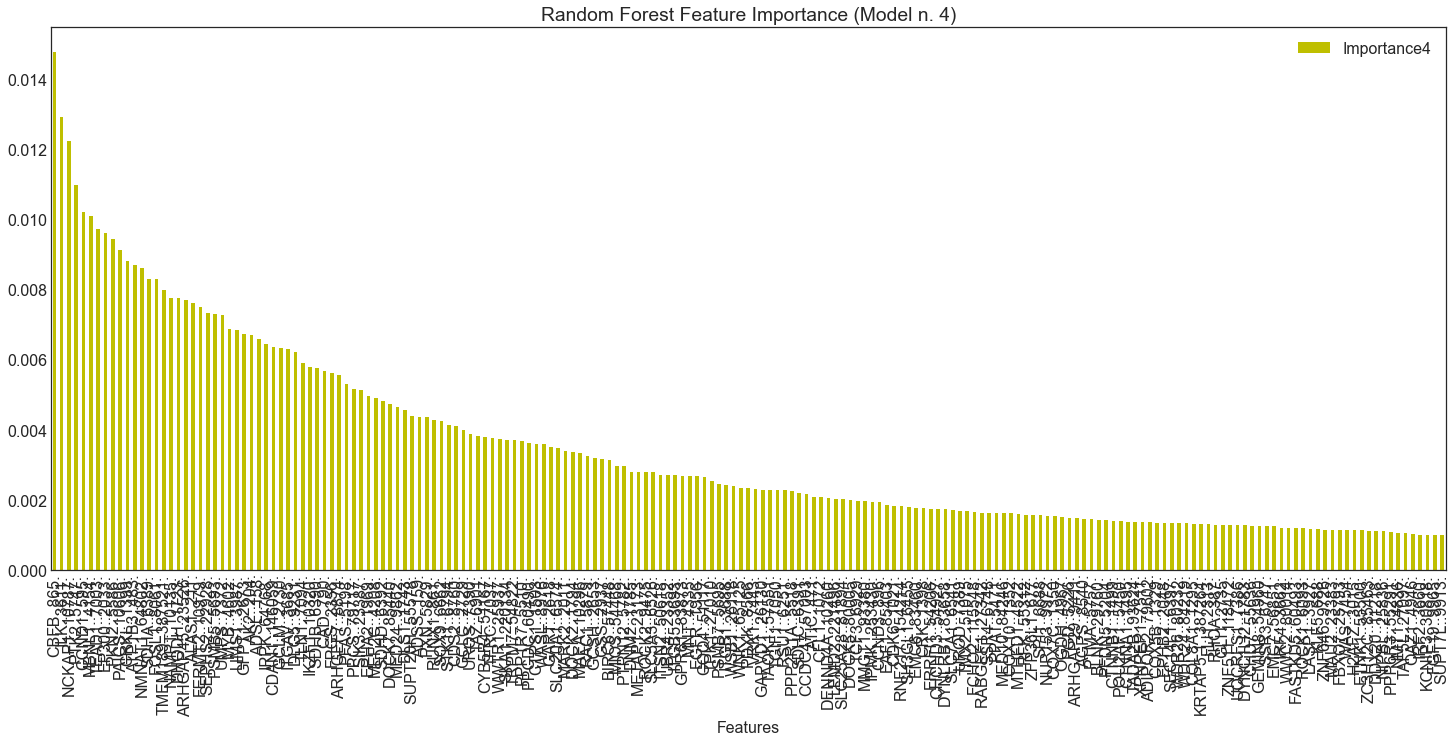

In [109]:
feat_impo_all[3].plot.bar(figsize = (25, 10), color = 'y')
plt.title('Random Forest Feature Importance (Model n. 4)')
plt.xlabel('Features')
plt.show()

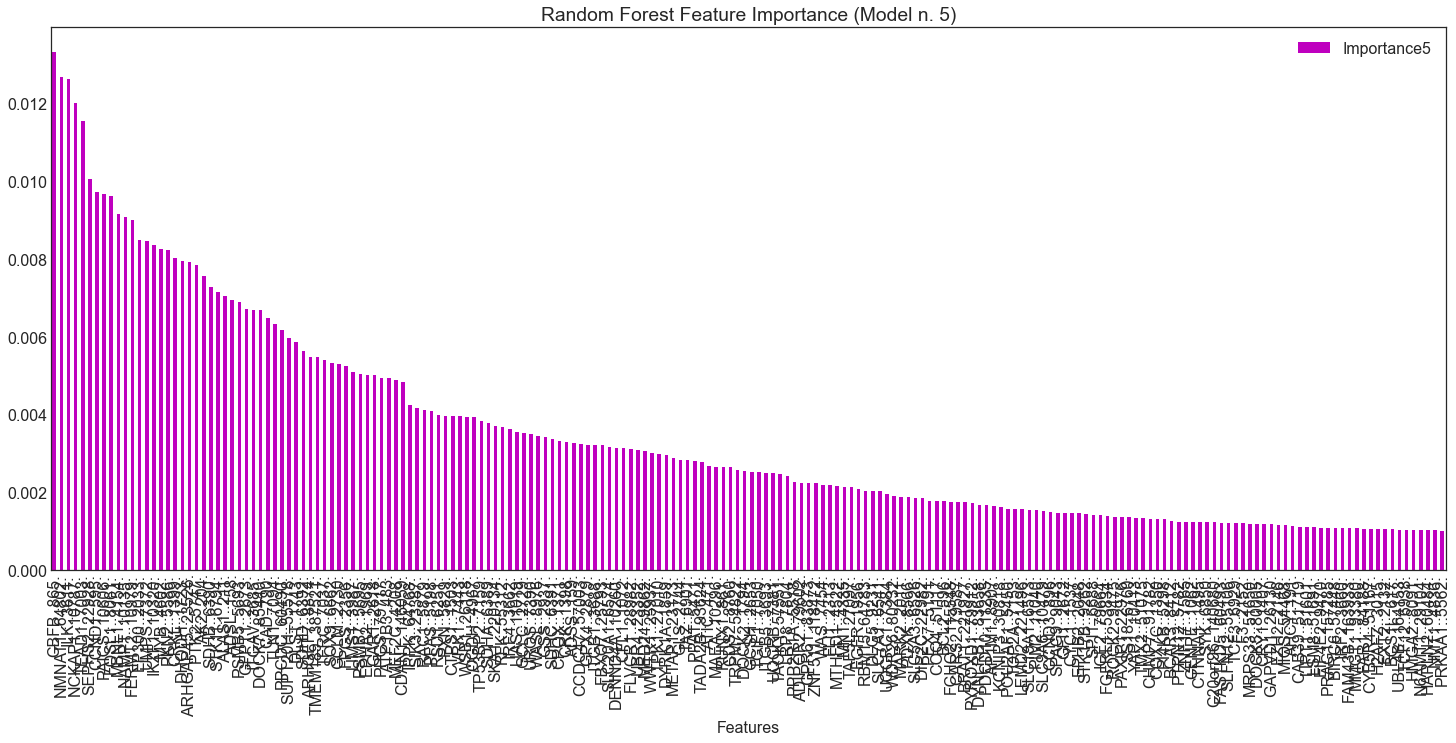

In [110]:
feat_impo_all[4].plot.bar(figsize = (25, 10), color = 'm')
plt.title('Random Forest Feature Importance (Model n. 5)')
plt.xlabel('Features')
plt.show()

In [111]:
df0 = pd.DataFrame(feat_impo_all[0])
df1 = pd.DataFrame(feat_impo_all[1])
df2 = pd.DataFrame(feat_impo_all[2])
df3 = pd.DataFrame(feat_impo_all[3])
df4 = pd.DataFrame(feat_impo_all[4])

In [112]:
most_feat_impo = pd.concat([df0, df1, df2, df3, df4], axis = 1)
most_feat_impo

,Importance1,Importance2,Importance3,Importance4,Importance5
CBFB..865.,0.012869,0.013200,0.014028,0.014770,0.013316
CCND1..595.,0.012307,0.011073,0.013278,0.010214,0.009739
MBNL1..4154.,0.012283,0.010778,0.012535,0.010103,0.009161
NMNAT1..64802.,0.012277,0.008189,0.012381,0.008619,0.012682
ILK..3611.,0.012002,0.011022,0.012872,0.012925,0.012622
...,...,...,...,...,...
BCS1L..617.,NaN,NaN,NaN,NaN,0.001048
UBL4B..164153.,NaN,NaN,NaN,NaN,0.001044
TCF12..6938.,NaN,NaN,NaN,NaN,0.001044
N6AMT1..29104.,NaN,NaN,NaN,NaN,0.001038


In [113]:
most_feat_impo = most_feat_impo.dropna()
most_feat_impo['Importance_mean'] = most_feat_impo.mean(axis = 1)
most_feat_impo

<ipython-input-113-2789dce5513e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_feat_impo['Importance_mean'] = most_feat_impo.mean(axis = 1)


,Importance1,Importance2,Importance3,Importance4,Importance5,Importance_mean
CBFB..865.,0.012869,0.013200,0.014028,0.014770,0.013316,0.013637
CCND1..595.,0.012307,0.011073,0.013278,0.010214,0.009739,0.011322
MBNL1..4154.,0.012283,0.010778,0.012535,0.010103,0.009161,0.010972
NMNAT1..64802.,0.012277,0.008189,0.012381,0.008619,0.012682,0.010830
ILK..3611.,0.012002,0.011022,0.012872,0.012925,0.012622,0.012289
...,...,...,...,...,...,...
MTHFD1..4522.,0.001349,0.003262,0.002058,0.001614,0.002155,0.002088
IRF4..3662.,0.001288,0.001383,0.004412,0.001211,0.003628,0.002384
MED24..9862.,0.001184,0.003717,0.003943,0.004664,0.003075,0.003317
CCDC47..57003.,0.001159,0.001738,0.002509,0.002168,0.003257,0.002166


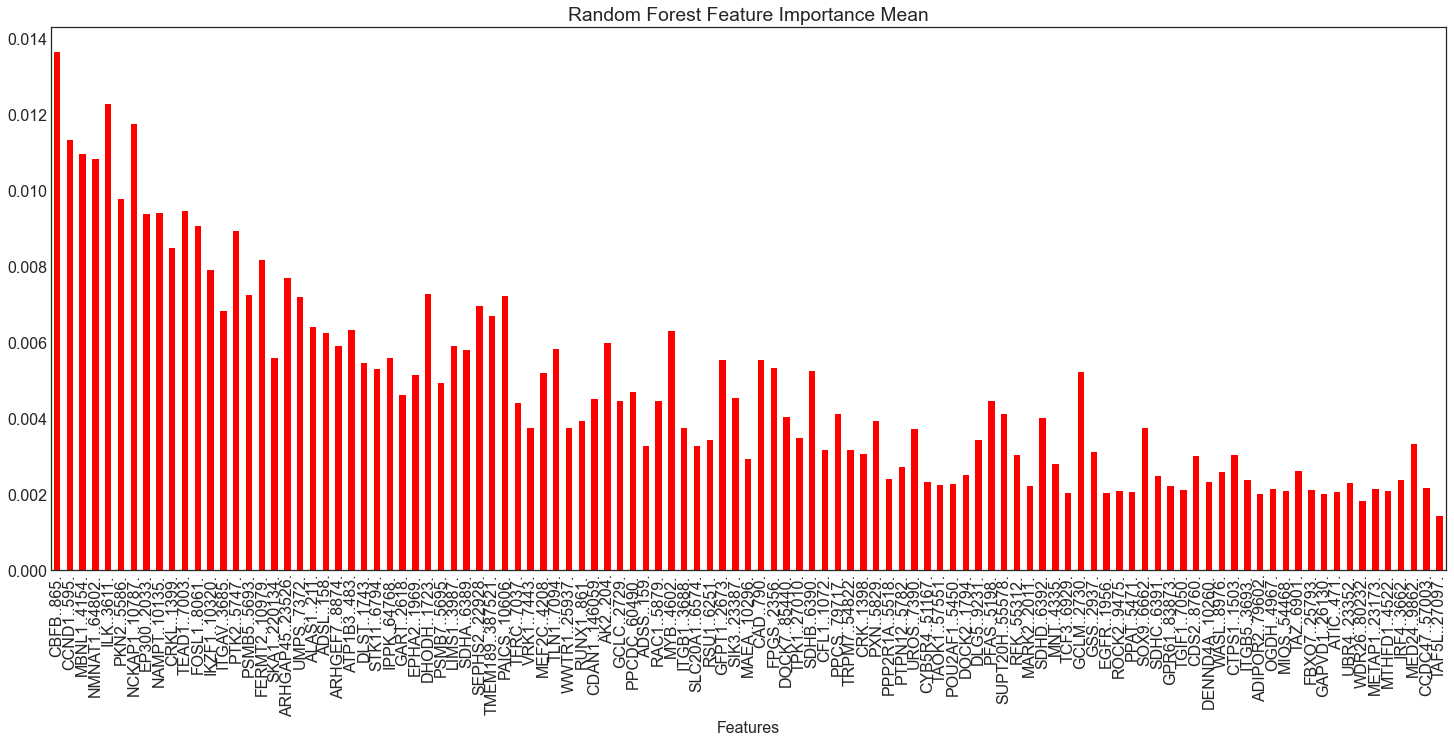

In [114]:
most_feat_impo.Importance_mean.plot.bar(figsize = (25, 10), color = 'r')
plt.title('Random Forest Feature Importance Mean')
plt.xlabel('Features')
plt.show()

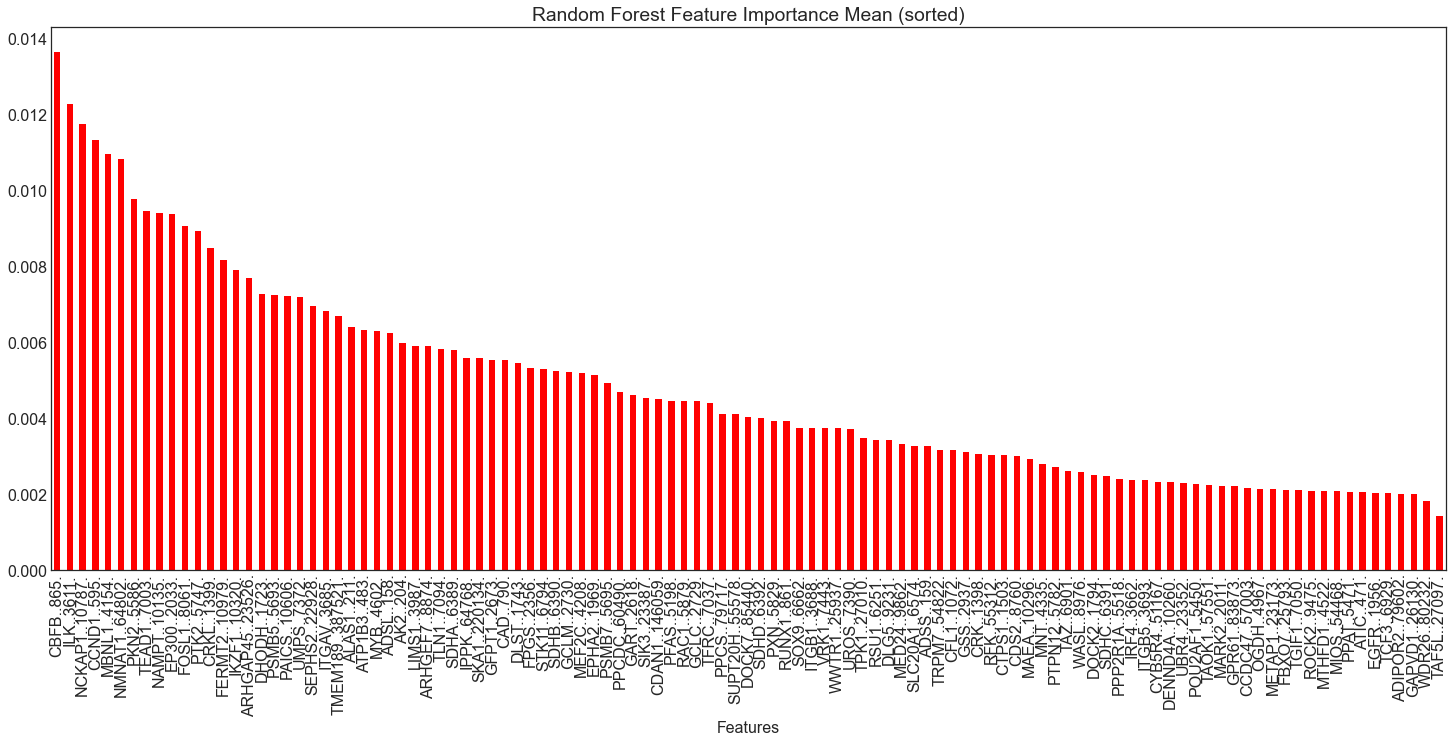

In [115]:
most_feat_impo = most_feat_impo.sort_values('Importance_mean', ascending = False)
most_feat_impo.Importance_mean.plot.bar(figsize = (25, 10), color = 'r')
plt.title('Random Forest Feature Importance Mean (sorted)')
plt.xlabel('Features')
plt.show()

--------------------

--------------------
**Questions**: If I do average the 5 feature importance values for each feature, select the top 200, and then do another 5-fold cross-validation on the model with the top 200 features, is it meaningful? Or will this cause leaking and overfitting since the feature selection was based off of all the data because I averaged the importances from all 5 models from the cross-validation?

A more rigorous way to pursue this question is to apply the **Boruta algorithm**. Boruta repeatedly measures feature importance from a random forest (or similar method) and then carries out statistical tests to screen out the features which are irrelevant. The procedure terminates when all features are either decisively relevant or decisively irrelevant.


SEE LATER

--------------------

--------------------

### 4. Pruned Random Forest classifier
Imbalance dataset, weighted class.

Looking at the documentation of RandomForestClassifier, we see the attribute *ccp_alpha* (non-negative float, default = 0.0).

This is the complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. By default, no pruning is performed.

In [116]:
rf_pruned = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                    ccp_alpha = 0.0005,
                    n_estimators = 500, max_depth = 45,
                    min_samples_split = 20, min_samples_leaf = 25,
                    class_weight = "balanced_subsample",
                    bootstrap = True, oob_score = True)

rf_pruned.fit(X_train, y_train)
print('Training score: ', rf_pruned.score(X_train, y_train))
print('Test score: ', rf_pruned.score(X_test, y_test))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training score:  0.996328029375765
Test score:  0.9951219512195122


The accuracy of the model is 99.5 %
Predicted 18 obs out of 19 True obs


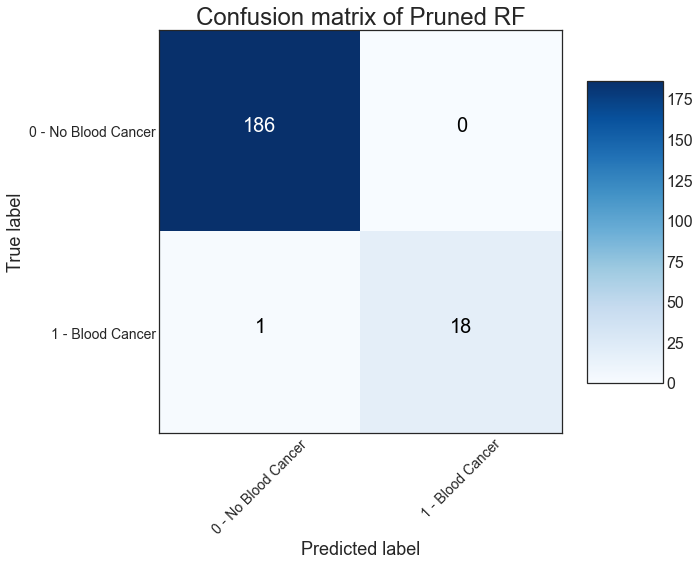

In [117]:
y_pred = rf_pruned.predict(X_test)
accuracy_score(y_test, y_pred)
print(f'The accuracy of the model is {round(accuracy_score(y_test, y_pred), 3)*100} %')

print(f'Predicted {y_pred.sum()} obs out of {y_test.sum()} True obs')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,
        classes = ['0 - No Blood Cancer', '1 - Blood Cancer'],
        title = 'Confusion matrix of Pruned RF',
        cmap = plt.cm.Blues)

# Same as before

Train ROC AUC Score: 0.9999541494727189
Test ROC AUC Score: 0.9994340690435767
Recall Baseline: 1.0 - Test: 0.95, Train: 0.99
Precision Baseline: 0.09 - Test: 1.0, Train: 0.98
Roc Baseline: 0.5 - Test: 1.0, Train: 1.0


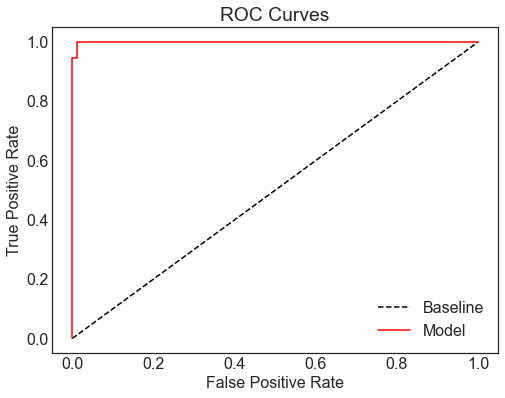

In [118]:
train_predictions = rf_pruned.predict(X_train)
train_probs = rf_pruned.predict_proba(X_train)[:, 1]
probs = rf_pruned.predict_proba(X_test)[:, 1]

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC Score: {roc_auc_score(y_test, probs)}')

# ROC Curve
evaluate_model(y_pred, y_test, probs, y_train, train_predictions, train_probs)

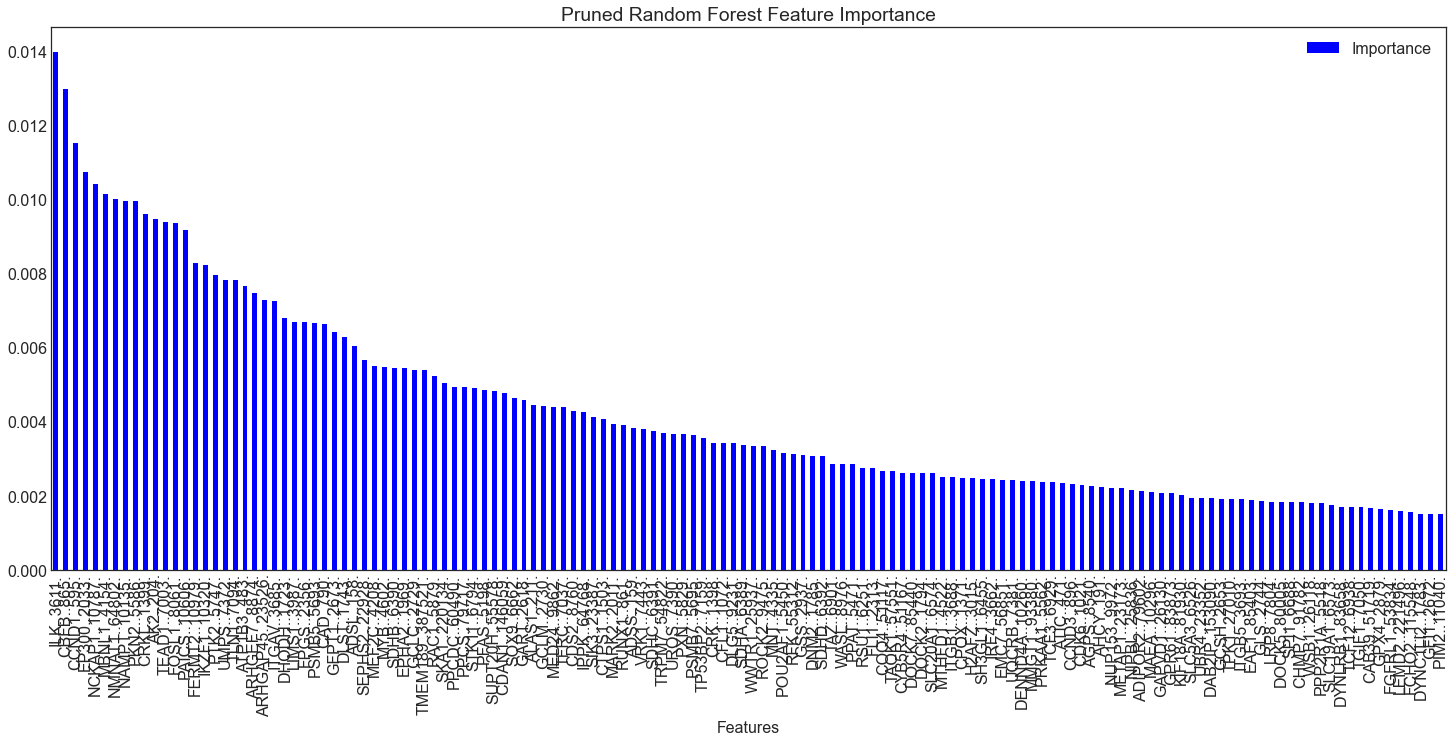

In [119]:
feat_impo_new = pd.DataFrame(rf_pruned.feature_importances_,
                        index = X_train.columns,
                        columns = ['Importance']).sort_values('Importance', ascending = False)
                        
feat_impo_new[feat_impo_new.Importance > 0.0015].plot.bar(figsize = (25, 10), color = 'b')
plt.title('Pruned Random Forest Feature Importance')
plt.xlabel('Features')
plt.show()

In [120]:
select_feat = feat_impo_new.loc[most_feat_impo.index]
select_feat = select_feat.sort_values('Importance', ascending = False)

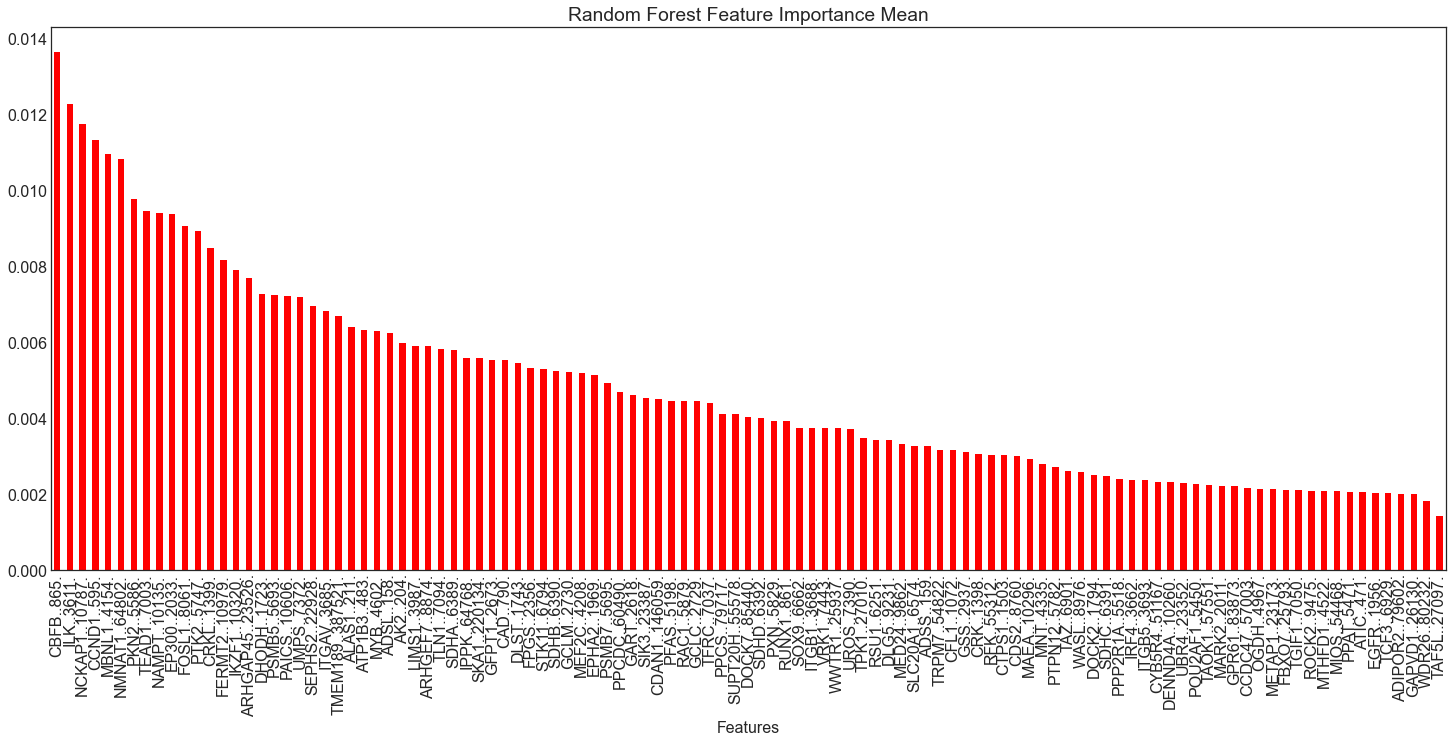

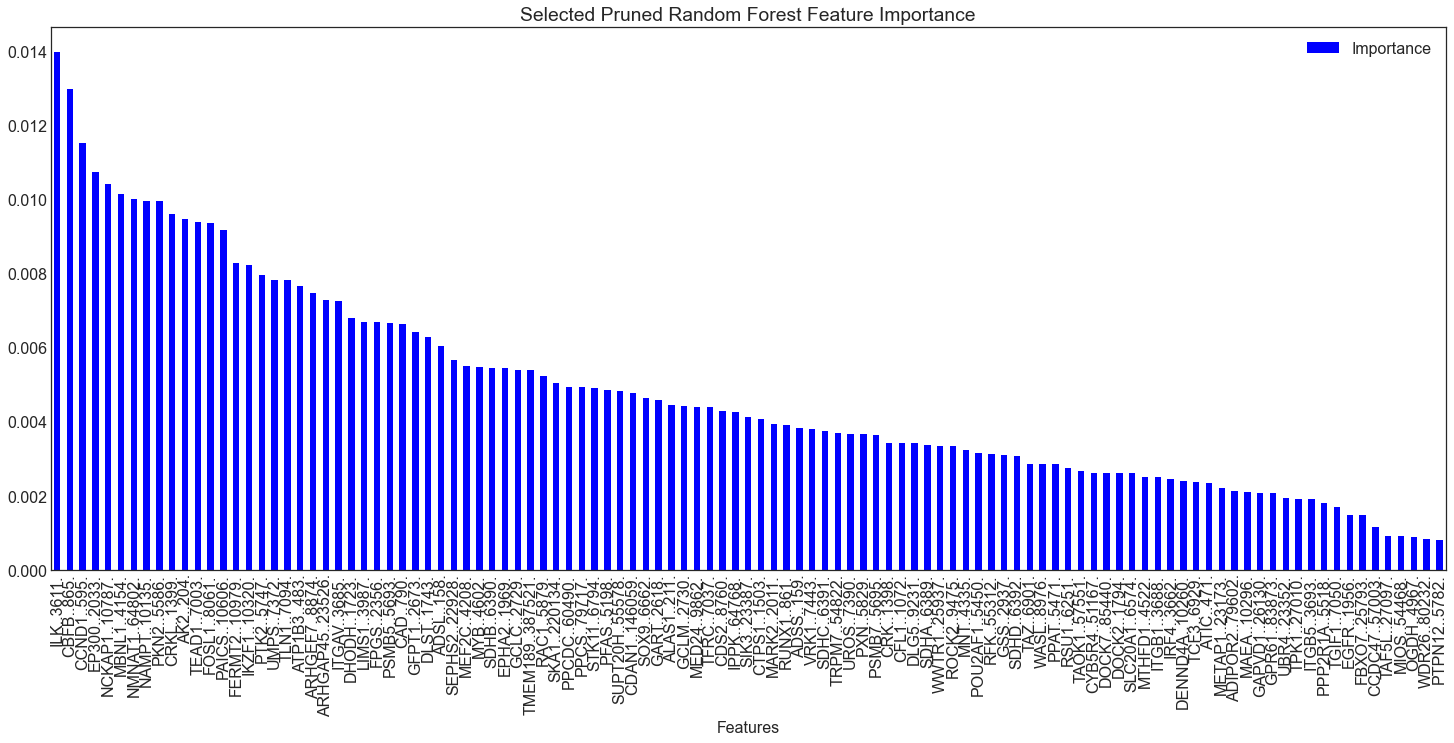

In [121]:
most_feat_impo.Importance_mean.plot.bar(figsize = (25, 10), color = 'r')
plt.title('Random Forest Feature Importance Mean')
plt.xlabel('Features')
plt.show()


select_feat.plot.bar(figsize = (25, 10), color = 'b')
plt.title('Selected Pruned Random Forest Feature Importance')
plt.xlabel('Features')
plt.show()

# cosa carina: plottarli nello stesso grafico, con le barre uno di fianco all'altro

### 5. Boruta algorithm
**Questions**: If I do average the 5 feature importance values for each feature, select the top 200, and then do another 5-fold cross-validation on the model with the top 200 features, is it meaningful? Or will this cause leaking and overfitting since the feature selection was based off of all the data because I averaged the importances from all 5 models from the cross-validation?

A more rigorous way to pursue this question is to apply the **Boruta algorithm**. 

Boruta repeatedly measures feature importance from a Random Forest (or similar method) and then carries out statistical tests to screen out the features which are irrelevant. The procedure terminatess when a score has been generated for all the features (aka all features are either decisively relevant or decisively irrelevant), or we reach the maximum runs set for the random forest. Here the steps of Boruta algorithm:

1. Create copies of all the original features present in your dataset.
1. Add randomness by shuffling these new feature. This is done to ensure that these new features show no correlation with the response variable.
1. Run random forest classifier on the extended dataset and generate feature importance score based on mean accuracy decrease estimate for all the shadow variables.
1. Compare Z-score of original variable with the maximum Z-score of shadow variables. Real features that have low score compared to the best of shadow features are deemed unimportant.
1. Remove shadow features and repeat the process until an importance score is generated for all the variables.

In [122]:
from boruta import BorutaPy

In [123]:
# Defining a general Random Forest Classifier
rf = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                    n_estimators = 500, max_depth = 45,
                    min_samples_split = 20, min_samples_leaf = 25,
                    class_weight = "balanced_subsample",
                    bootstrap = True, oob_score = True)

rf.fit(X_train, y_train)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForestClassifier(class_weight='balanced_subsample', max_depth=45,
                       min_samples_leaf=25, min_samples_split=20,
                       n_estimators=500, n_jobs=-1, oob_score=True,
                       random_state=2311)

In [124]:
# Defining parameters of boruta object for feature selection
feat_selection = BorutaPy(rf, n_estimators = 'auto', verbose = 1, 
                        max_iter = 25, random_state = 2311)

# Get relevant features
feat_selection.fit(np.array(X_train), np.array(y_train))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 1 / 25


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 2 / 25


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 3 / 25


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 4 / 25


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 5 / 25


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 6 / 25


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 7 / 25


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 8 / 25


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 9 / 25


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 10 / 25


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 11 / 25


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 12 / 25


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 13 / 25


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 14 / 25


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 15 / 25


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 16 / 25


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 17 / 25


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 18 / 25


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 19 / 25


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 20 / 25


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 21 / 25


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 22 / 25


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 23 / 25


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Iteration: 24 / 25


BorutaPy finished running.

Iteration: 	25 / 25
Confirmed: 	89
Tentative: 	27
Rejected: 	17061


BorutaPy(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                          max_depth=45, min_samples_leaf=25,
                                          min_samples_split=20, n_estimators=57,
                                          n_jobs=-1, oob_score=True,
                                          random_state=RandomState(MT19937) at 0x2B214374E40),
         max_iter=25, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2B214374E40, verbose=1)

In [129]:
# Getting all relevant features
feat_selection.support_

array([False, False, False, ..., False, False, False])

In [130]:
# Getting feature ranking
feat_selection.ranking_

array([11326, 11326, 11326, ...,  3343, 11326,  3343])

In [131]:
# Selecting only selected features by using transform() function
feat_selection.transform(np.array(X_train))

array([[0.97494908, 0.96932327, 0.1534347 , ..., 0.05924947, 0.38606708,
        0.81308501],
       [0.87136643, 0.12823193, 0.02275085, ..., 0.03460768, 0.02729691,
        0.27057504],
       [0.93517679, 0.88290232, 0.08880309, ..., 0.04103034, 0.45129318,
        0.63309014],
       ...,
       [0.09716982, 0.0910649 , 0.03506206, ..., 0.04380788, 0.07704337,
        0.8763389 ],
       [0.98525844, 0.92513768, 0.00585711, ..., 0.02904527, 0.17319823,
        0.08740776],
       [0.30060597, 0.06804502, 0.00544546, ..., 0.14913273, 0.03092972,
        0.25392933]])

In [132]:
# Creating list of varibale name, ranks, and final decision using zip
feat_rankings = list(zip(X_train.columns,
                           feat_selection.ranking_,
                           feat_selection.support_))

# Printing the list of varibales which got selected
count = 0
for i in feat_rankings:
    if i[2] == True:
        count += 1
        print(f'count: {count}  Name: {i[0]} Rank: {i[1]}')

count: 1  Name: ADSL..158. Rank: 1
count: 2  Name: ADSS..159. Rank: 1
count: 3  Name: AGPS..8540. Rank: 1
count: 4  Name: AK2..204. Rank: 1
count: 5  Name: ALAS1..211. Rank: 1
count: 6  Name: ARHGAP45..23526. Rank: 1
count: 7  Name: ARHGEF7..8874. Rank: 1
count: 8  Name: ATP1B3..483. Rank: 1
count: 9  Name: CAB39..51719. Rank: 1
count: 10  Name: CAD..790. Rank: 1
count: 11  Name: CBFB..865. Rank: 1
count: 12  Name: CCND1..595. Rank: 1
count: 13  Name: CDAN1..146059. Rank: 1
count: 14  Name: CDS2..8760. Rank: 1
count: 15  Name: CFL1..1072. Rank: 1
count: 16  Name: CHMP7..91782. Rank: 1
count: 17  Name: CRK..1398. Rank: 1
count: 18  Name: CRKL..1399. Rank: 1
count: 19  Name: CYB5R4..51167. Rank: 1
count: 20  Name: DAB2IP..153090. Rank: 1
count: 21  Name: DHODH..1723. Rank: 1
count: 22  Name: DLG5..9231. Rank: 1
count: 23  Name: DLST..1743. Rank: 1
count: 24  Name: DOCK2..1794. Rank: 1
count: 25  Name: EAF1..85403. Rank: 1
count: 26  Name: EGFR..1956. Rank: 1
count: 27  Name: EP300..2033.

In [140]:
list_feat_impo = list(most_feat_impo.index)

count = 0
bor_feat_impo = []
for i in feat_rankings:
    if i[2] == True:
        bor_feat_impo.append(i[0])
        count += 1

In [143]:
len(list_feat_impo), len(bor_feat_impo)

(109, 89)

In [153]:
important_feature = []
disc_important_feature = []

for feat in list_feat_impo:
    if feat in bor_feat_impo:
        important_feature.append(feat)
    else:
        disc_important_feature.append(feat)

len(important_feature), len(disc_important_feature)

most_feat_impo.loc[important_feature]

,Importance1,Importance2,Importance3,Importance4,Importance5,Importance_mean
CBFB..865.,0.012869,0.013200,0.014028,0.014770,0.013316,0.013637
ILK..3611.,0.012002,0.011022,0.012872,0.012925,0.012622,0.012289
NCKAP1..10787.,0.010707,0.012207,0.011534,0.012242,0.012020,0.011742
CCND1..595.,0.012307,0.011073,0.013278,0.010214,0.009739,0.011322
MBNL1..4154.,0.012283,0.010778,0.012535,0.010103,0.009161,0.010972
...,...,...,...,...,...,...
ROCK2..9475.,0.002436,0.002531,0.001307,0.002800,0.001367,0.002088
MTHFD1..4522.,0.001349,0.003262,0.002058,0.001614,0.002155,0.002088
PPAT..5471.,0.002401,0.001397,0.002099,0.001634,0.002817,0.002070
EGFR..1956.,0.002451,0.001631,0.001277,0.002681,0.002095,0.002027


We notice that some of the important features found by Boruta algorithm have not been detected by our 5-fold cross validation.

In [186]:
col = ['DepMap_ID'] + important_feature + ['label']

blood_train[col].head()

,DepMap_ID,CBFB..865.,ILK..3611.,NCKAP1..10787.,CCND1..595.,MBNL1..4154.,NMNAT1..64802.,PKN2..5586.,TEAD1..7003.,NAMPT..10135.,...,MARK2..2011.,GPR61..83873.,METAP1..23173.,TGIF1..7050.,ROCK2..9475.,MTHFD1..4522.,PPAT..5471.,EGFR..1956.,TCF3..6929.,label
0,ACH-000352,0.106291,0.079542,0.237175,0.997692,0.395612,0.215371,0.097347,0.103990,0.952546,...,0.034388,0.747475,0.311415,0.085445,0.098124,0.684015,0.990537,0.008230,0.072829,0
1,ACH-000966,0.025671,0.789753,0.623786,0.975773,0.053273,0.060179,0.907587,0.332161,0.411722,...,0.498275,0.833103,0.863938,0.138778,0.041837,0.272447,0.792452,0.179731,0.061316,0
2,ACH-002181,0.173307,0.736693,0.387211,1.000000,0.076299,0.399079,0.689675,0.466033,0.179288,...,0.155137,0.818802,0.391369,0.115305,0.210016,0.042192,0.388946,0.323804,0.158316,0
3,ACH-000435,0.156899,0.125768,0.258764,0.545652,0.101160,0.038454,0.067578,0.072197,0.588283,...,0.349840,0.856927,0.044190,0.104188,0.021300,0.155807,0.946544,0.272685,0.074407,0
4,ACH-000322,0.072198,0.881570,0.271027,0.906893,0.409359,0.238736,0.151802,0.040277,0.352780,...,0.017291,0.791863,0.132154,0.036575,0.024163,0.605556,0.972586,0.035034,0.067550,0


In [184]:
blood_train[col].to_csv('dataset/blood_filt_train.csv')
blood_test[col].to_csv('dataset/blood_filt_test.csv')

In [187]:
col_bor = ['DepMap_ID'] + bor_feat_impo + ['label']

blood_train[col_bor].to_csv('dataset/blood_filt_bor_train.csv')
blood_test[col_bor].to_csv('dataset/blood_filt_bor_test.csv')